<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  

#  Gravitational Wave Open Data Workshop #2


#### Tutorial 2.4: Parameter estimation on GW150914 using open data.

This example estimates the non-spinning parameters of the binary black hole system using
commonly used prior distributions. This will take about 40 minutes to run.
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2019/blob/master/Day_2/Tuto_2.4_Parameter_estimation_for_compact_object_mergers.ipynb)

More examples at https://lscsoft.docs.ligo.org/bilby/examples.html


##  Installation  (execute only if running on a cloud platform!)

In [1]:
# -- Use the following line in Google Colab
#! pip install -q 'lalsuite==6.66' 'bilby==0.6.6' 'gwpy==1.0.1'

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

We begin by importing some commonly used functions

In [2]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

## Bilby version

In [3]:
print(bilby.__version__)

0.6.6:


In this notebook, we'll analyse GW150914, first we need to know the trigger time. This can be found on the [GWOSC page](https://www.gw-openscience.org/events/GW150914/), here we define it as a variable

In [4]:
time_of_event = 1126259462.4

## Set up empty interferometers
We need to get some data to analyse. We'll be using data from the Hanford (H1) and Livinston (L1) ground-based gravitational wave detectors. To organise ourselves, we'll create two "empty" interferometers. These are empty in the sense that they don't have any strain data. But, they know about the orientation and location of their respective namesakes. It may also be interesting to note that they are initialised with the planned design sensitivity power spectral density of advanced LIGO - we'll overwrite this later on, but it is often useful for simulations.

In [5]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

## Download the data

To analyse the signal, we need to download analyis data. Here, we will use [gwpy](https://gwpy.github.io/) to download the open strain data. For a general introduction to reading/writing data with gwpy, see [the documentation](https://gwpy.github.io/docs/stable/timeseries/).

To analyse GW150914, we will use a 4s period duration centered on the event itself. It is standard to choose the data such that it always includes a "post trigger duration of". That is, there is always 2s of data after the trigger time. We therefore define all times relative to the trigger time, duration and this post-trigger duration.

In [6]:
# Definite times in relatation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

# Use gwpy to fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

L1_analysis_data = TimeSeries.fetch_open_data(
    "L1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

/home/user1/anaconda3/envs/bilby-release/lib/python3.7/site-packages/gwpy/types/series.py:926: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


Here, `H1_analysis_data` and its L1 counterpart are gwpy TimeSeries objects. As such, we can plot the data itself out:

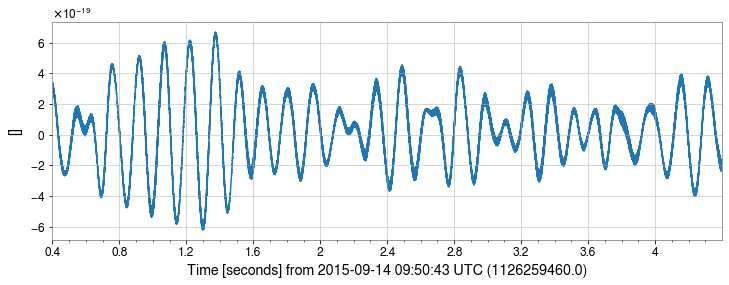

In [7]:
H1_analysis_data.plot()
plt.show()

This doesn't tell us much of course! It is dominated by the low frequency noise.

## Initialise the bilby inteferometers with the strain data

Now, we pass the downloaded strain data to our `H1` and `L1` bilby inteferometer objects. For other methods to set the strain data, see the various `set_strain_data*` methods.

In [8]:
H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

## Download the power spectral data

Parameter estimation relies on having a power spectral density (PSD) - an estimate of the coloured noise properties of the data. Here, we will create a PSD using off-source data (for discussion on methods to estimate PSDs, see, e.g. [Chatziioannou et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvD.100j4004C/abstract)) 

Again, we need to download this from the open strain data. We start by figuring out the amount of data needed - in this case 32 times the analysis duration.

In [9]:
psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

/home/user1/anaconda3/envs/bilby-release/lib/python3.7/site-packages/gwpy/types/series.py:926: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


Having obtained the data to generate the PSD, we now use the standard [gwpy psd](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.psd) method to calculate the PSD. Here, the `psd_alpha` variable is converting the `roll_off` applied to the strain data into the fractional value used by `gwpy`.

In [10]:
psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

## Initialise the PSD
Now that we have psd's for H1 and L1, we can overwrite the `power_spectal_density` attribute of our interferometers with a new PSD.

In [11]:
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=L1_psd.value)

## Looking at the data
Okay, we have spent a bit of time now downloading and initializing things. Let's check that everything makes sense. To do this, we'll plot our analysis data alongwise the amplitude spectral density (ASD); this is just the square root of the PSD and has the right units to be comparable to the frequency-domain strain data.

10:36 bilby INFO    : Generating frequency domain strain from given time domain strain.
10:36 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


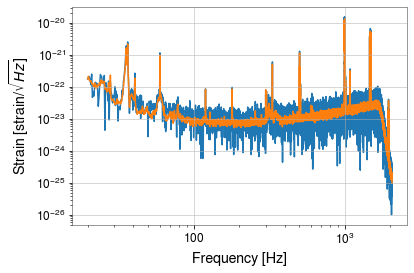

In [12]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

What is happening at high frequencies? This is an artefact of the downsampling applied to the data - note that we downloaded the 4096Hz data which is downsamples for 16384Hz. We aren't really interested in the data at these high frequencies so let's adjust the maximum frequency used in the analysis to 1024 Hz and plot things again.

In [13]:
H1.maximum_frequency = 1024
L1.maximum_frequency = 1024

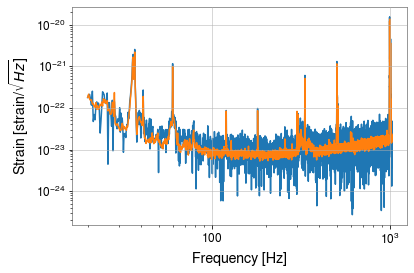

In [14]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

Okay, that is better - we now won't analyse any data near to the artefact produced by downsampling. Now we have some sensible data to analyse so let's get right on with down the analysis!

## Low dimensional analysis

As a start, let's run a short (~1min on a single 2.8GHz core), chirp-mass only parameter estimation analysis. This is done by defining a prior dictionary where all parameters are fixed, and only the chirp-mass is allowed to vary.

### Create a prior

Here, we create a prior - this defined the prior space we'll explore. In order to make things fast we set lots of parameters to fixed values

In [15]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066


## Create a likelihood

For Bayesian inference, we need to evaluate the likelihood. In Bilby, we create a likelihood object. This is the communication interface between the sampling part of Bilby and the data. Explicitly, when Bilby is sampling it only uses the `parameters` and `log_likelihood()` of the likelihood object. This means the likelihood can be arbitrarily complicated and the sampling part of Bilby won't mind a bit!

Let's great a `GravitationalWaveTransient`, a special inbuilt method carefully designed to wrap up evaluating the likelihood of a waveform model in some data.

In [16]:
# First, put our "data" created above into a list of intererometers (the order is arbitrary)
interferometers = [H1, L1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
    waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=False)

10:36 bilby WARNING : The waveform_generator start_time is not equal to that of the provided interferometers. Overwriting the waveform_generator.


### Run the analysis

Now that the prior is set-up and the likelihood is set-up (with the data and the signal mode), we can run the sampler to get the posterior result. This function takes the likelihood and prior along with some options for how to do the sampling and how to save the data.

In [17]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="GW150914",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    sample="unif", nlive=500, dlogz=3  # <- Arguments are used to make things fast - not recommended for general use
)

10:36 bilby INFO    : Running for label 'GW150914', output will be saved to 'short'
10:36 bilby INFO    : Using LAL version Branch: None;Tag: lalsuite-v6.66;Id: 04a60e3ac9b6ecb285cf96d1137c6a62a3d5cfde;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
10:36 bilby INFO    : Search parameters:
10:36 bilby INFO    :   chirp_mass = Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
10:36 bilby INFO    :   mass_ratio = Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
10:36 bilby INFO    :   time_jitter = Uniform(minimum=-0.000244140625, maximum=0.000244140625, name=None, latex_label=None, unit=None, boundary='periodic')
10:36 bilby INFO    :   phase = 0.0
10:36 bilby INFO    :   geocent_time = 1126259460.3999023
10:36 bilby INFO    :   a_1 = 0.0
10:36 bilby INFO    :   a_2 = 0.0
10:36 bilby INFO    :   tilt_1 = 0.0
10:36 bilby INFO    :   tilt_2 = 0.0
10:36 bi

0it [00:00, ?it/s]

10:36 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'unif', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f719cfa6dd0>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
10:36 bilby INFO    : Checkpoint every check_point_delta_t = 600s
10:36 bilby INFO    : Using dynesty version 1.0.1
10:36 bilby INFO    : Resume file short/GW150914_resume.pick

973it [00:38, 25.38it/s, bound:0 nc:1 ncall:3272 eff:45.0% logz-ratio=268.04+/-0.13 dlogz:0.005>3.00] 

10:36 bilby INFO    : Sampling time: 0:00:00


10:36 bilby INFO    : Reconstructing marginalised parameters.


100%|██████████| 1473/1473 [03:46<00:00,  6.50it/s]


10:40 bilby INFO    : Computing SNRs for every sample.


100%|██████████| 1473/1473 [00:15<00:00, 92.93it/s]


10:40 bilby INFO    : Summary of results:
nsamples: 1473
ln_noise_evidence: -8534.562
ln_evidence: -8266.518 +/-  0.132
ln_bayes_factor: 268.043 +/-  0.132



The `run_sampler` returned `result_short` - this is a Bilby result object. The posterior samples are stored in a pandas data frame (think of this like a spreadsheet), let's take a look at it

In [18]:
result_short.posterior

,chirp_mass,mass_ratio,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,...,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source,H1_matched_filter_snr,H1_optimal_snr,L1_matched_filter_snr,L1_optimal_snr
0,30.422752,0.770451,-0.000002,5.236468,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,36.674968,28.256279,27.976931,64.931247,19.777251-1.474469j,14.059048,14.336481-0.793271j,9.999093
1,30.503443,0.693047,-0.000124,1.577023,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,38.835312,26.914677,28.051136,65.749989,19.919592+0.898876j,13.978503,14.338873+0.794396j,9.928665
2,31.501885,0.681412,0.000032,1.136541,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,40.460113,27.570007,28.969309,68.030120,19.932450+0.057676j,14.333939,14.030233+0.031318j,10.161948
3,30.620438,0.680073,-0.000175,1.384766,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,39.368179,26.773232,28.158725,66.141411,19.552191+4.113110j,13.998825,14.005374+3.106691j,9.938668
4,30.517241,0.822688,-0.000172,2.061926,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,35.575278,29.267344,28.063824,64.842622,19.750465-0.923752j,14.145831,14.294333-0.678010j,10.064707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,31.400747,0.973767,-0.000038,5.091087,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,33.614574,32.732779,28.876302,66.347353,19.895706+2.667017j,14.555877,14.173269+1.952320j,10.348402
1469,31.400747,0.973767,-0.000038,2.059420,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,33.614574,32.732779,28.876302,66.347353,20.066630-0.803492j,14.555877,14.307421-0.474878j,10.348402
1470,31.400747,0.973767,-0.000038,5.184282,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,33.614574,32.732779,28.876302,66.347353,20.028356+1.337431j,14.555877,14.265248+1.125730j,10.348402
1471,31.400747,0.973767,-0.000038,5.159725,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,33.614574,32.732779,28.876302,66.347353,20.041734+1.285035j,14.555877,14.278499+1.035317j,10.348402


We can pull out specific parameters that we are interested in

In [19]:
result_short.posterior["chirp_mass"]

0       30.422752
1       30.503443
2       31.501885
3       30.620438
4       30.517241
          ...    
1468    31.400747
1469    31.400747
1470    31.400747
1471    31.400747
1472    31.400747
Name: chirp_mass, Length: 1473, dtype: float64

and plot them in a histogram

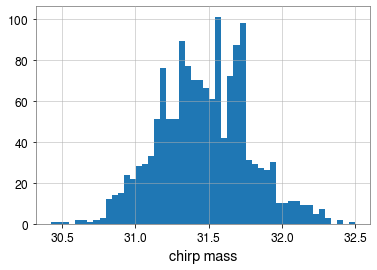

In [20]:
fig, ax = plt.subplots()
ax.hist(result_short.posterior["chirp_mass"], bins=50)
ax.set_xlabel("chirp mass")
plt.show()

The result object also has in-built methods to make nice plots such as corner plots. You can add the priors if you are only plotting parameter which you sampled in, e.g.

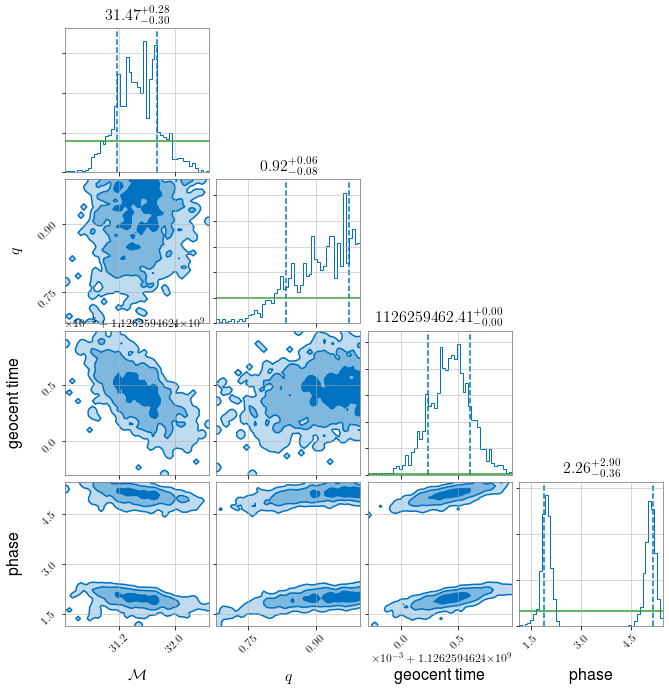

In [21]:
result_short.plot_corner(["chirp_mass", "mass_ratio", "geocent_time", "phase"], priors=True)

You can also plot lines indicating specific points. Here, we add the values recorded on [GWOSC](https://www.gw-openscience.org/events/GW150914/). Notably, these fall outside the bulk of the posterior uncertainty here. This is because we limited our prior - if instead we ran the full analysis these agree nicely.

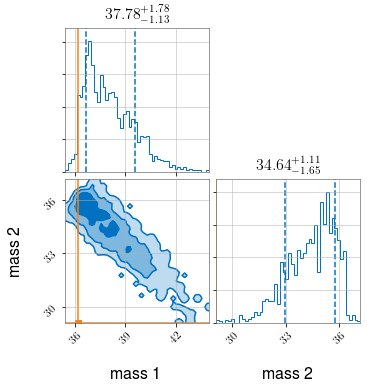

In [22]:
parameters = dict(mass_1=36.2, mass_2=29.1)
result_short.plot_corner(parameters)

The result object also stores meta data, like the priors

In [23]:
result_short.priors

{'chirp_mass': Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'phase': Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=None, boundary=None),
 'geocent_time': Uniform(minimum=1126259462.3000002, maximum=1126259462.5, name='geocent_time', latex_label='$t_c$', unit=None, boundary=None),
 'a_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'a_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_12': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_jl': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'dec': DeltaFunction(peak=-1.2232, name=None, 

and details of the analysis itself:

In [24]:
result_short.sampler_kwargs["nlive"]

500

Finally, we can also get out the Bayes factor for the signal vs. Gaussian noise:

In [25]:
print("log10 Bayes factor = {} +/- {}".format(
    result_short.log_10_bayes_factor, result_short.log_10_evidence_err))

log10 Bayes factor = 116.40978809698058 +/- 0.05732354742373029
